In [ ]:
import numpy.random as rdm
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy
import scipy.fftpack

Consideramos, aqui, o modelo de Ising com interações de longo alcance sob ação de um campo gaussiano aleatório. O Hamiltoniano é dado por:

$$
H = -\sum_{i<j} J(r_{ij}) s_i s_j - \sum_i h_i s_i
$$

Sendo $J(r_{ij})$ o coeficiente de acoplamento entre os spins $s_i$ e $s_j$

$$
J(r) = \frac{1}{r^{1+\sigma}}
$$

Onde $N$ é o número de spins e $\sigma$ é um parâmetro que controla o alcance das interações. Para $\sigma = 0$ temos o modelo de Ising com interações de curto alcance e para $\sigma = \infty$ temos o modelo de Sherrington-Kirkpatrick. O termo $h_i$ é o campo aleatório gaussiano dado por:

$$
P(h_i) = \frac{1}{\sqrt{2\pi\Delta^2}} e^{-\frac{h_i^2}{2\Delta^2}}
$$

Onde $\Delta$ é a variância do campo aleatório, que controla a força de desordem.

Definimos a densidade de defeito $\rho(t)$ como o número de spins desalinhados dividido por $N$. O excesso de densidade de defeito no tempo $t$ é

$$ \rho_{ex}(t) = \rho(t) - \rho(t=\infty)$$

Com isto, somos capazes de avaliar a evolução do domínio, pela relação

$$ R(t) = \langle\overline{\rho_{ex}(t)}\rangle^{-1}$$

Para estudar o crescimento do domínio quantitativamente, calculamos o expoente dinâmico efetivo $z_{ef}$, como sendo:

$$z_{ef}(t,\Delta) =  \left[ \frac{d\ln R(t)}{d \ln t} \right]^{-1}$$

A função de correlação espacial será:

$$ C(r,t) = \frac{1}{N} \sum_{i=1}^{N} [\langle \overline{s_i(t) s_{i+r}(t)}\rangle - \langle \overline{s_i(t)} \rangle \langle \overline{s_{i+r}(t)} \rangle] $$

O fator de estrutura da rede $S(k,t)$ é obtida a partir de uma transformada de Fourier da função de correlação, isto é:

$$ S(k,t) = \sum_i e^{ikr} C(r,t) $$

As correlações temporais são descritas via função de autocorrelação, dada por:

$$A(t,t_w) = \frac{1}{N} \sum_{i=1}^{N} [\langle \overline{s_i(t) s_{i}(t_w)}\rangle - \langle \overline{s_i(t)} \rangle \langle \overline{s_{i}(t_w)} \rangle] $$
onde $t_w(<t)$ é o tempo de espera (waiting) que descreve a idade do sistema.

A magnetização é obtida através da flutuação média dos spins, escrita por:

\begin{equation}
M = \sum_i \langle \sigma_i \rangle = \Biggl\langle \sum_i \sigma_i \Biggr\rangle = \frac{1}{Z} Tr \left[ \left( \sum_i \sigma_i \right) e^{\beta H}  \right]
\end{equation}

Podemos derivar a magnetização em relação ao campo para obter a susceptibilidade, descrita por:

\begin{equation}
\begin{split}
\chi &= \frac{1}{N} \frac{\partial{M}}{\partial h} \\
&= \frac{\beta}{N} \left[ \Biggl \langle \left( \sum_i \sigma_i \right)^2 \Biggr\rangle -   \left( \Biggl\langle \sum_i \sigma_i  \Biggr \rangle \right)^2 \right]
\end{split}
\end{equation}

Decorre que, $\chi_{ij} =\beta( \langle \sigma_i \sigma_j \rangle - \langle \sigma_i \rangle \langle \sigma_j \rangle )$ mede as flutuações ao redor do valor médio de $\sum \sigma_i$ que é a magnetização. A partir disso, definimos a função de correlação como sendo:

\begin{equation}
C_{ij} = \langle \sigma_i \sigma_j \rangle - \langle \sigma_i \rangle \langle \sigma_j \rangle  = \frac{\chi_{ij}}{\beta}
\end{equation}
 e é uma grandeza obtida também a partir da função de correlação.

O calor específico será obtido através da energia do sistema:

\begin{equation}
C_v = \frac{\beta^2}{N} (\langle E^2 \rangle - \langle E \rangle ^2)
\end{equation}

onde $E$ é a energia do sistema descrita pela Hamiltoniana.

## Códigos

### Funções

Nessa primeira parte estão descritas as funções das grandezas energia e magnetização, as demais decorrem destas. Além disso, está descrito o campo gaussiano ($grf$) e o algoritmo de Metropolis para a mudança de estados dos spins.

In [ ]:
# estado inicial
def inicial(N):
    state = 2*rdm.randint(2,size=N)-1
    return state

# campo aleatorio gaussiano
def grf(N):
    alpha = 1.0
    delta = 1.0
    flag_normalize = True

    k_idx = np.mgrid[:N] - int( (N + 1)/2 )
    k_idx = scipy.fftpack.fftshift(k_idx)

    amplitude = np.power( k_idx**2 + 1e-10, -alpha/4.0 )
    amplitude[0] = 0

    noise = rdm.normal(size=(N)) \
        + 1j * rdm.normal(size=(N))

    gfield = numpy.fft.ifft(noise * amplitude).real

    if flag_normalize:
        gfield = gfield - np.mean(gfield)
        gfield = delta*gfield/np.std(gfield)

    return gfield

# Spin flip
def spin_flip(beta,config):
    nb = 0
    for i in range(N):
        a = rdm.randint(N)
        s = config[a]
        for j in range(N):
            if j != a:
                nb += config[(j)%N]
        cost = 2*s*nb # cost = 2*E (E1 - E0 = 2E)
        if cost < 0:
            s *= -1
        elif rdm.rand() < math.exp(-cost*beta):
            s *= -1
        config[a] = s
    return config

# Energia
def energy(config,alpha):
    e = 0
    h = grf(N)
    for i in range(N):
        for j in range(i,N):
            if i != j:
                e += -config[i]*config[j]/(abs(i-j)**alpha) - h[i]*config[i]
    return e

# Magnetizacao
def magnetization(config):
    m = np.sum(config)
    return m

# Densidade de defeito
def defeito(config):
    d = 0
    h = grf(N)
    for i in range(N):
        if config[i] != h[i]:
            d += 1
    return d

### Parâmetros (1)

Abaixo estão os parâmetros da simução, com as funções dependentes da Temperatura (T)

In [ ]:
nt     = 100        #  number of temperature points
N      = 2**4       #  size of the lattice, N
alpha = 2.          #  exponent of the long range interaction
eqSteps = 500       #  number of MC sweeps for equilibration
mcSteps = 500       #  number of MC sweeps for calculation

# valores de temperatura
T       = np.linspace(1, 200, nt);


time    = np.linspace(0, 100, mcSteps)
E,M,C,X,Cr,Rho = np.zeros(nt), np.zeros(nt), np.zeros(nt), np.zeros(nt), np.zeros(nt), np.zeros(nt)
n1, n2  = 1.0/(mcSteps*N*N), 1.0/(mcSteps*mcSteps*N*N)

In [ ]:
# Funcoes variando com a temperatura
config = inicial(N)
for tt in range(nt):
    E1 = M1 = E2 = M2 = 0
    # config = inicial(N)
    iT=1/T[tt]; iT2=iT*iT; # Termos referentes à temperatura => beta = 1/kT, k=1 é a constante de Boltzmann

    for i in range(eqSteps):         # equilibrate
        spin_flip(iT,config)         # Monte Carlo moves

    for i in range(mcSteps):
        spin_flip(iT,config)
        Ene = energy(config,alpha)     # calculate the energy
        Mag = magnetization(config)        # calculate the magnetisation

        E1 = E1 + Ene
        M1 = M1 + Mag
        M2 = M2 + Mag*Mag
        E2 = E2 + Ene*Ene

        E[tt] = E1*n1
        M[tt] = M1*n1
        C[tt] = (E2*n1 - E1*E1*n2)*iT2
        X[tt] = (M2*n1 - M1*M1*n2)*iT


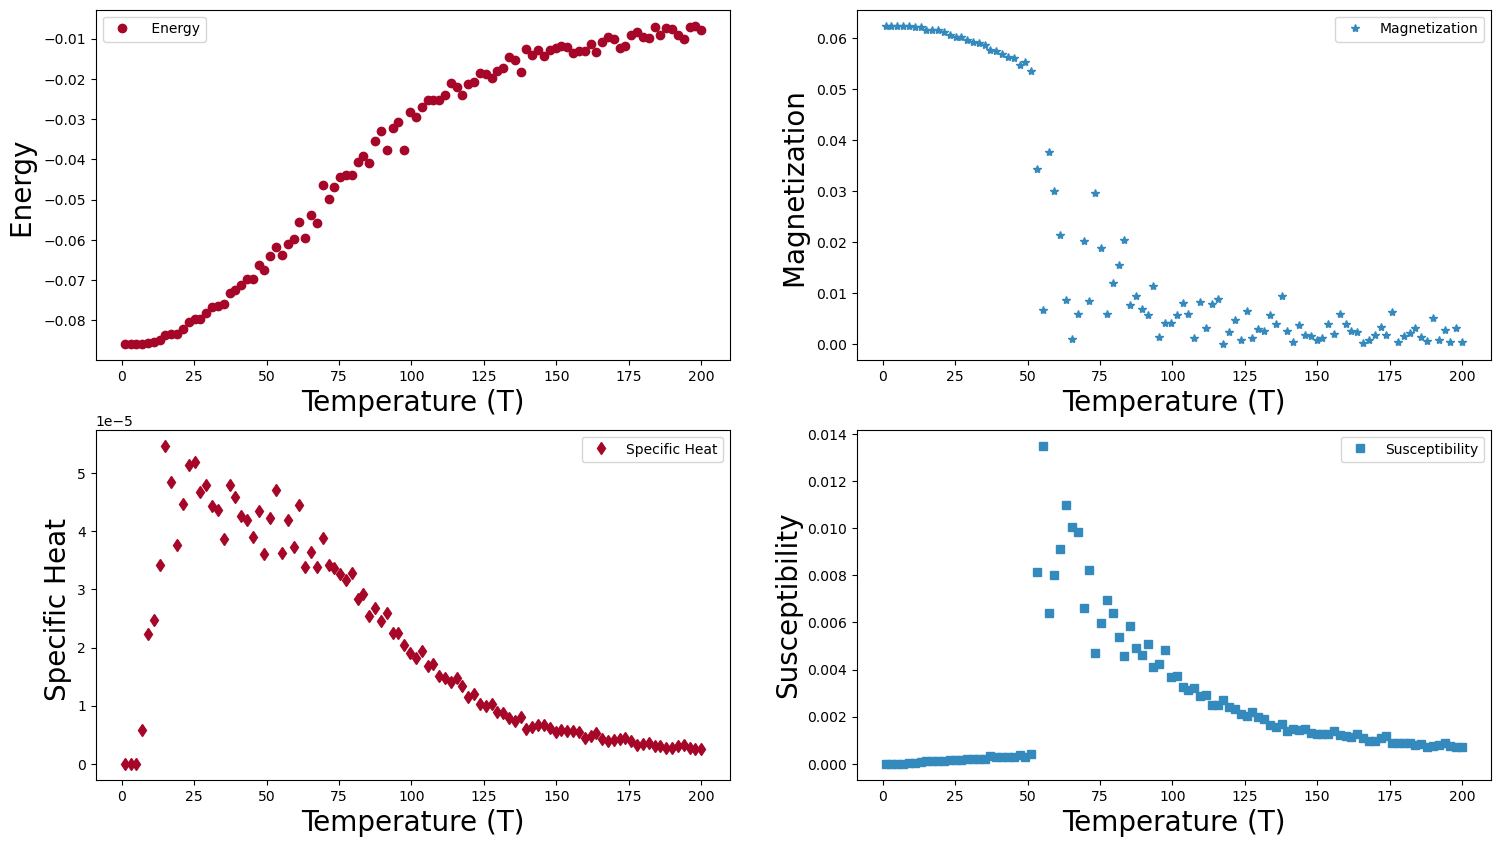

In [ ]:
f = plt.figure(figsize=(18, 10)); # plot the calculated values

sp =  f.add_subplot(2, 2, 1 );
plt.plot(T, E, 'o', color="#A60628", label=' Energy');
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Energy ", fontsize=20);
plt.legend(loc='best');

sp =  f.add_subplot(2, 2, 2 );
plt.plot(T, abs(M), '*', color="#348ABD", label='Magnetization');
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Magnetization ", fontsize=20);
plt.legend(loc='best');

sp =  f.add_subplot(2, 2, 3 );
plt.plot(T, C, 'd', color="#A60628", label='Specific Heat');
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Specific Heat ", fontsize=20);
plt.legend(loc='best');

sp =  f.add_subplot(2, 2, 4 );
plt.plot(T, X, 's', color="#348ABD", label='Susceptibility');
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Susceptibility", fontsize=20);
plt.legend(loc='best');

### Parâmetros (2)

Abaixo estão os parâmetros da simução, com as funções dependentes do tempo (t), onde o tempo é medido em passos de Monte Carlo (mcSteps) e com a temperatura fixa

In [ ]:
nt     = 100         #  number of temperature points
N      = 2**6        #  size of the lattice, N x N
alpha  = 1.5         #  exponent of the long range interaction
eqSteps = 1000       #  number of MC sweeps for equilibration
mcSteps = 1000       #  number of MC sweeps for calculation

# valores de temperatura
T = 5

time    = np.linspace(0, nt, mcSteps)
E,M,C,X,Cr,Rho = np.zeros(mcSteps), np.zeros(mcSteps), np.zeros(mcSteps), np.zeros(mcSteps), np.zeros(mcSteps), np.zeros(mcSteps)
n1, n2  = 1.0/(mcSteps*N), 1.0/(mcSteps*mcSteps*N*N)

In [ ]:
# Funcoes variando com o tempo

for tt in range(mcSteps):
    E1 = M1 = E2 = M2 = D = 0
    config = inicial(N)
    iT=1/T; iT2=iT*iT;

    for i in range(eqSteps):         # equilibrate
        spin_flip(iT,config)         # Monte Carlo moves

    for i in range(mcSteps):
        spin_flip(iT,config)
        Ene = energy(config,alpha)     # calculate the energy
        Mag = magnetization(config)        # calculate the magnetisation
        Def = defeito(config)

        E1 = E1 + Ene
        M1 = M1 + Mag
        M2 = M2 + Mag*Mag
        E2 = E2 + Ene*Ene
        D = D + Def

        E[tt] = E1*n1
        M[tt] = M1*n1
        C[tt] = (E2*n1 - E1*E1*n2)*iT2
        X[tt] = (M2*n1 - M1*M1*n2)*iT
        Rho[tt] = 1/(n1*D)




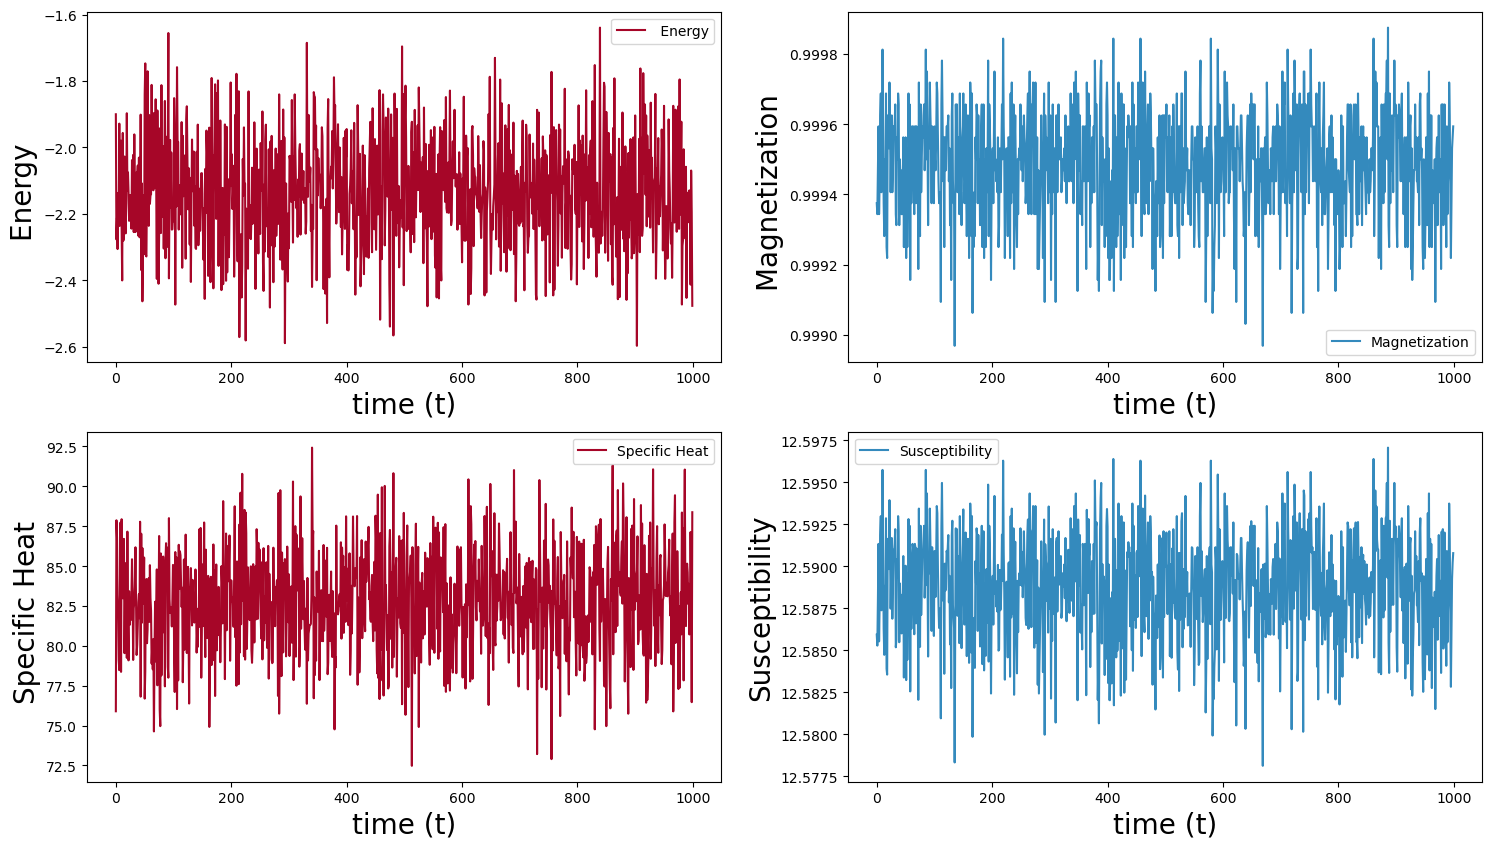

In [ ]:
f = plt.figure(figsize=(18, 10)); # plot the calculated values

sp =  f.add_subplot(2, 2, 1 );
plt.plot(E, color="#A60628", label=' Energy');
plt.xlabel("time (t)", fontsize=20);
plt.ylabel("Energy ", fontsize=20);
plt.legend(loc='best');

sp =  f.add_subplot(2, 2, 2 );
plt.plot(abs(M), color="#348ABD", label='Magnetization');
plt.xlabel("time (t)", fontsize=20);
plt.ylabel("Magnetization ", fontsize=20);
plt.legend(loc='best');

sp =  f.add_subplot(2, 2, 3 );
plt.plot(C, color="#A60628", label='Specific Heat');
plt.xlabel("time (t)", fontsize=20);
plt.ylabel("Specific Heat ", fontsize=20);
plt.legend(loc='best');

sp =  f.add_subplot(2, 2, 4 );
plt.plot(X, color="#348ABD", label='Susceptibility');
plt.xlabel("time (t)", fontsize=20);
plt.ylabel("Susceptibility", fontsize=20);
plt.legend(loc='best');

Notas de aula, Eric Andrade, IF-USP: https://drive.google.com/file/d/1BifggXt5BT8V9qrdVn6YVFbRPjEGe1MW/view